# DBSCAN

## Introduction
DBSCAN(Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm.  
The data are clustered based on the density of the data points.


## Definition
- Epsilon: The distance that defines the nearby points. If the distance between two points is less than epsilon, then they are nearby points.
- Min Points: The minimum number of points to form a cluster.
- Core Point: A point is a core point if there are at least min Points nearby within the distance epsilon.
- Border Point: A point is a border point if there are less than min Points nearby within the distance epsilon, but the point is reachable from a core point.
- Noise Point: A point is a noise point that is neither a core point nor a border point.
- Cluster: A cluster is a set of core points and border points that are density-reachable from the core points.

## Algorithm
1. Set the Hyperparameters: epsilon and min Points. 
2. Randomly select a point P.  
3. Find all the points nearby P within the distance epsilon.
4. If the number of points nearby P not less than min Points, then P is a core point.
5. All the points nearby P are in the same cluster. Merge the clusters if they have common points. 
6. Repeat the process 2 to 5 until all the points are visited.  

## Hyperparameters
1. epsilon: The distance to find the nearby points.
2. min Points: The minimum number of points to form a cluster.

## Implementation

In [1]:
import numpy as np

class DBSCAN:
    def __init__(self, epsilon:float, minPoints:int):
        self.epsilon = epsilon
        self.minPoints = minPoints
    
    def fit(self, X:np.ndarray):
        n, m = X.shape
        self.labels = np.full(n, -1) # undefined label is -1
        self.cluster_cnt = 0
        
        for i in range(n):
            if self.labels[i] != -1:
                continue
            neighbours = self._find_neighbours(X, i)
            # Density check
            if len(neighbours) < self.minPoints:
                self.labels[i] = 0 # Noise point
                continue
            self.cluster_cnt += 1 # new cluster
            self.labels[i] = self.cluster_cnt # label core point
            self._expand_cluster(X, neighbours) # expand cluster
    
    def _expand_cluster(self, X: np.ndarray, neighbours: np.ndarray):
        i = 0
        while i < len(neighbours):
            j = neighbours[i]
            
            if self.labels[j] == 0:  # noise point -> border point
                self.labels[j] = self.cluster_cnt
            
            if self.labels[j] == -1:  # undefined point -> core point or border point
                self.labels[j] = self.cluster_cnt  
                
                new_neighbours = self._find_neighbours(X, j) 
                if len(new_neighbours) >= self.minPoints:
                    neighbours = np.concatenate((neighbours, new_neighbours)) # merge the clusters
            
            i += 1  
            
    def _find_neighbours(self, X:np.ndarray, i:int):
        return np.where(np.linalg.norm(X - X[i], axis=1) < self.epsilon)[0]

### Test

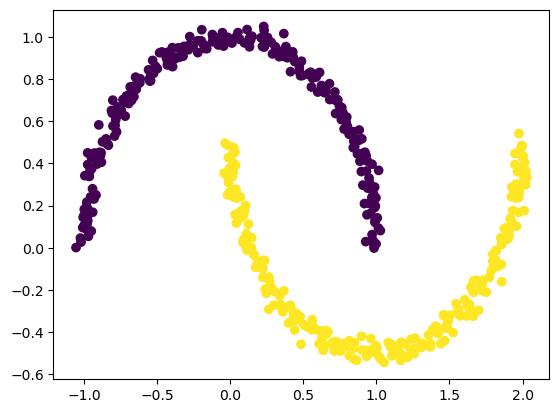

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.03, random_state=44)

dbscan = DBSCAN(epsilon=0.1, minPoints=5)
dbscan.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels)
plt.show()

### Hyperparameters Tuning
Hyperparameter is Tuned by:
- Grid Search
    - using Silhouette Score
- Elbow Method
    - used to find the optimal epsilon value

#### Grid Search
Grid search is used to find the optimal hyperparameters. It is computationally expensive but it is effective. Uses the Silhouette Score to find the optimal hyperparameters.

In [48]:
def silhouette_score(X, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) <= 1:
        return 0
    n = len(X)
    a = np.zeros(n)
    b = np.zeros(n)
    for i in range(n):
        if labels[i] == 0:
            continue
        same_cluster = labels==labels[i]
        a[i] = np.mean(np.linalg.norm(X[same_cluster] - X[i], axis=1))
        
        min_b = np.inf
        for label in unique_labels:
            if label == labels[i] or label == 0:
                continue
            other_cluster = labels==label
            min_b = min(min_b, np.mean(np.linalg.norm(X[other_cluster] - X[i], axis=1)))
            
        b[i] = min_b
        
    with np.errstate(divide='ignore', invalid='ignore'):
        s = np.where(np.maximum(a, b) > 0, (b - a) / np.maximum(a, b), 0)
        
    return np.mean(s[labels!=0])

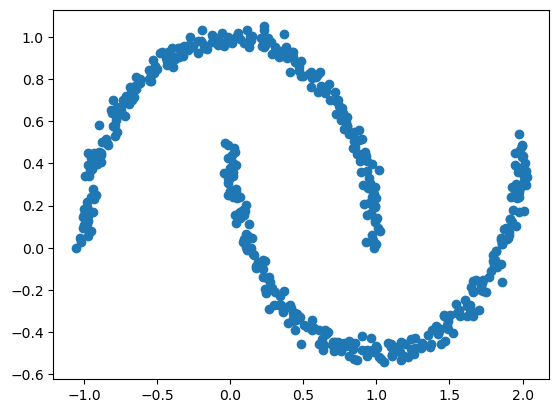

In [49]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.03, random_state=44)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [50]:
# Grid Search
best_score = -1
best_epsilon = -1
best_minPoints = -1
for epsilon in np.linspace(0.05, 0.3, 10):
    for minPoints in range(3, 10):
        dbscan = DBSCAN(epsilon=epsilon, minPoints=minPoints)
        dbscan.fit(X)
        score = silhouette_score(X, dbscan.labels)
        if score > best_score:
            best_score = score
            best_epsilon = epsilon
            best_minPoints = minPoints
print("Best epsilon:", best_epsilon)
print("Best minPoints:", best_minPoints)
print("Best Score:", best_score)

Best epsilon: 0.05
Best minPoints: 9
Best Score: 0.7756903180605322


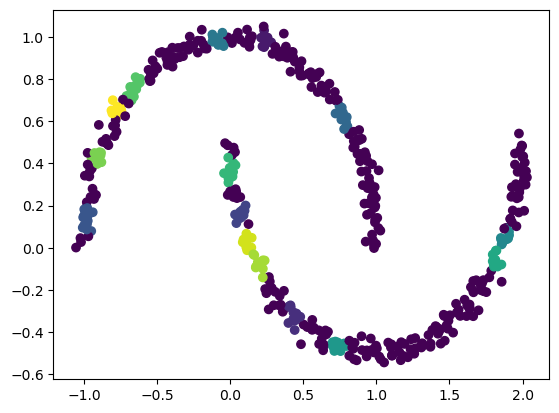

In [51]:
dbscan= DBSCAN(epsilon=best_epsilon, minPoints=best_minPoints)
dbscan.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels)
plt.show()

Grid search is computationally expensive. Also, it doesn't guarantee the optimal hyperparameters. From the above example, we can see that silhouette score doesn't work with very small epsilon values. So, we can use the Elbow method to find the optimal epsilon value.

#### Elbow Method

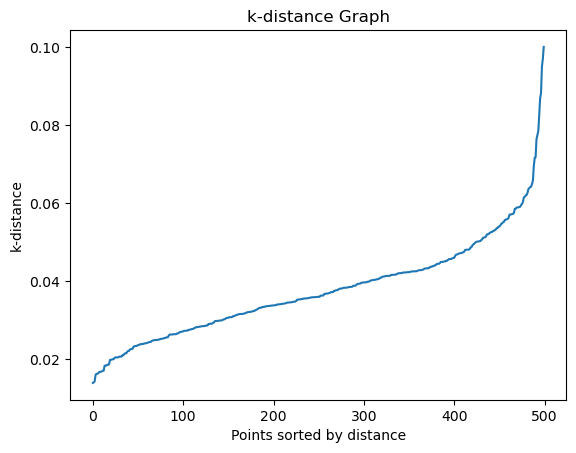

In [52]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Find the k-nearest neighbors
k = 4  # usually min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort and plot the distances
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.ylabel('k-distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance Graph')
plt.show()


Best Distance (Epsilon Value) is the point where the graph has the maximum curvature. From the above graph, we can see that the best epsilon value is around 0.07.

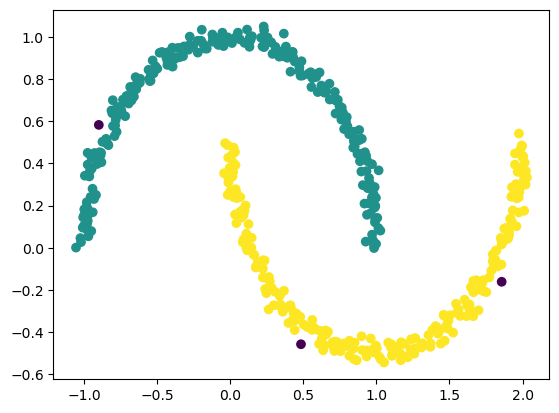

In [54]:
dbscan= DBSCAN(epsilon=0.07, minPoints=4)
dbscan.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels)
plt.show()